In [1]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multioutput import MultiOutputClassifier

In [2]:
base_dir = "/Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data"

dfs = []
for i in range(1, 43):
    sols_path = os.path.join(base_dir, f"maquette{i}", f"sols{i}.csv")
    if os.path.exists(sols_path):
        # Cherche la ligne d'en-tête réelle
        with open(sols_path, encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if line.startswith("Id;"):
                    header_row = idx
                    break
        try:
            df = pd.read_csv(sols_path, sep=';', header=header_row)
            dfs.append(df)
            print(f"Chargé : {sols_path} ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
            print(df.head())
        except Exception as e:
            print(f"Erreur de parsing : {sols_path} -> {e}")
    else:
        print(f"Fichier non trouvé : {sols_path}")

if dfs:
    sols_concat = pd.concat(dfs, ignore_index=True)
    print(f"Total concaténé : {sols_concat.shape[0]} lignes, {sols_concat.shape[1]} colonnes")
else:
    sols_concat = pd.DataFrame()
    print("Aucun fichier murs.csv trouvé.")

sols_concat.head()

Chargé : /Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data/maquette1/sols1.csv (45 lignes, 142 colonnes)
       Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation 014EC_Mode Constructif  \
0  860207        GO      PLANCHER            COURANT         PREDALLE USINE   
1  861048        GO      PLANCHER            COURANT         COULE EN PLACE   
2  862490        GO      PLANCHER            COURANT         PREDALLE USINE   
3  862746        GO      PLANCHER            COURANT         PREDALLE USINE   
4  862880        GO      PLANCHER            COURANT         PREDALLE USINE   

           Nom  Murs en intersection  Murs coupés (u)  \
0  Plancher 35                     0               46   
1  Plancher 32                     0               33   
2  Plancher 35                     0                9   
3  Plancher 35                     0               66   
4  Plancher 24                     9              360   

                                   Murs coupés (Ids)  Murs coupants (u) 

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,Murs en intersection,Murs coupés (u),Murs coupés (Ids),Murs coupants (u),...,str_terres,str_is_10,str_sur-place,str_extrait,Sol Niveau Fini,Sol Contrefleche,Classe Beton,Sol Description,Sol Epaisseur,STR_NIV_ref
0,860207,GO,PLANCHER,COURANT,PREDALLE USINE,Plancher 35,0,46,"846095,846097,846103,846107,846142,848603,8592...",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,861048,GO,PLANCHER,COURANT,COULE EN PLACE,Plancher 32,0,33,"846059,846077,846118,846151,846152,846153,8728...",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,862490,GO,PLANCHER,COURANT,PREDALLE USINE,Plancher 35,0,9,"846140,846142,848603,896351,896391,1263045,128...",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,862746,GO,PLANCHER,COURANT,PREDALLE USINE,Plancher 35,0,66,"846103,846107,846126,846129,846140,846142,8486...",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,862880,GO,PLANCHER,COURANT,PREDALLE USINE,Plancher 24,9,360,"846055,846057,846059,846060,846061,846064,8460...",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
sols_concat.shape

(6422, 353)

In [4]:
colonnes_a_garder = [
    "011EC_Lot",
    "012EC_Ouvrage",
    "013EC_Localisation",
    "014EC_Mode Constructif",
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel",
    "Famille et type"
]

# On ne garde que les colonnes présentes dans le DataFrame
sols_concat = sols_concat[[col for col in colonnes_a_garder if col in sols_concat.columns]]

In [5]:
import unicodedata
import re

def clean_col(col):
    # Enlever accents
    col = ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn')
    col = col.lower()
    # Remplacer espaces et tirets par _
    col = re.sub(r"[ \-\(\)]", "_", col)
    # Supprimer tout caractère non alphanumérique ou _
    col = re.sub(r"[^a-z0-9_]", "", col)
    # Nettoyer les doubles/triples underscores
    col = re.sub(r"_+", "_", col)
    # Supprimer _ en début/fin
    col = col.strip("_")
    return col

sols_concat.columns = [clean_col(c) for c in sols_concat.columns]
print(sols_concat.columns.tolist())

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'epaisseur', 'ouvertures', 'profil_modifie', 'materiau_structurel', 'famille_et_type']


In [6]:
targets = [
    "011ec_lot",
    "012ec_ouvrage",
    "013ec_localisation",
    "014ec_mode_constructif"
]

# Garder seulement les targets présents dans le DataFrame
targets_in_df = [col for col in targets if col in sols_concat.columns]

if not targets_in_df:
    raise ValueError(f"Aucune colonne cible trouvée dans poutres_concat. Colonnes disponibles : {sols_concat.columns.tolist()}")

# X et y_multi
X = sols_concat.drop(columns=targets_in_df)
y_multi = sols_concat[targets_in_df]

if X.shape[1] == 0:
    raise ValueError("Aucune variable explicative disponible après suppression des cibles. Vérifiez vos colonnes.")

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ]
)

# Pipeline complet avec MultiOutputClassifier et KNN
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MultiOutputClassifier(KNeighborsClassifier(n_neighbors=10)))
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

# Supprimer les lignes avec NaN dans les targets (train et test)
train_notna = y_train.notna().all(axis=1)
test_notna = y_test.notna().all(axis=1)
X_train, y_train = X_train[train_notna], y_train[train_notna]
X_test, y_test = X_test[test_notna], y_test[test_notna]
sols_concat.columns = [clean_col(c) for c in sols_concat.columns]

# Rendre les noms de colonnes uniques si besoin (compatible toutes versions pandas)
def deduplicate_columns(cols):
    seen = {}
    result = []
    for col in cols:
        if col not in seen:
            seen[col] = 0
            result.append(col)
        else:
            seen[col] += 1
            result.append(f"{col}.{seen[col]}")
    return result

sols_concat.columns = deduplicate_columns(sols_concat.columns)
print(sols_concat.columns.tolist())
# Entraînement
pipeline.fit(X_train, y_train)

# Sauvegarde du pipeline complet
joblib.dump(pipeline, 'knnsolspipeline.pkl')

print("Pipeline complet sauvegardé dans bimpredict_pipeline.pkl")

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'epaisseur', 'ouvertures', 'profil_modifie', 'materiau_structurel', 'famille_et_type']
Pipeline complet sauvegardé dans bimpredict_pipeline.pkl


In [7]:
print("Accuracy calculée sur", len(y_test), "échantillons.")

Accuracy calculée sur 1173 échantillons.


In [8]:
from sklearn.metrics import f1_score

# Générer les prédictions sur le jeu de test
y_pred = pipeline.predict(X_test)

# Calculer le F1-score pour chaque colonne (target) séparément
f1_micro_list = []
f1_macro_list = []
for i, col in enumerate(y_test.columns):
	f1_micro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='micro'))
	f1_macro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Moyenne des scores F1 sur toutes les cibles
f1_micro_mean = np.mean(f1_micro_list)
f1_macro_mean = np.mean(f1_macro_list)

print(f"F1 micro (moyenne par cible): {f1_micro_mean:.4f}")
print(f"F1 macro (moyenne par cible): {f1_macro_mean:.4f}")

F1 micro (moyenne par cible): 0.9354
F1 macro (moyenne par cible): 0.6703


In [9]:
import pandas as pd
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_per_label = []
for i, col in enumerate(y_test.columns):
    f1_per_label.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Récupérer les noms de labels
label_names = list(y_test.columns)

# Construire un DataFrame pour lecture facile
f1_report = pd.DataFrame({
    'Label': label_names,
    'F1-score': f1_per_label
})

# Trier du pire au meilleur
f1_report = f1_report.sort_values(by='F1-score')

# Afficher
print(f1_report)

                    Label  F1-score
3  014ec_mode_constructif  0.525154
2      013ec_localisation  0.527085
1           012ec_ouvrage  0.637411
0               011ec_lot  0.991439


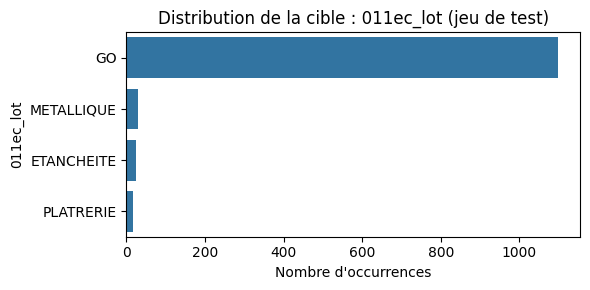

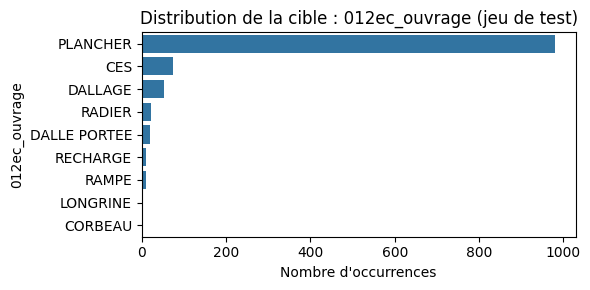

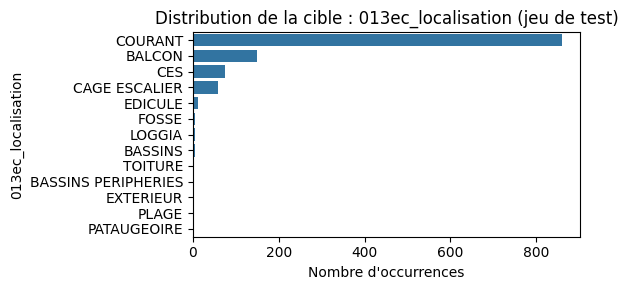

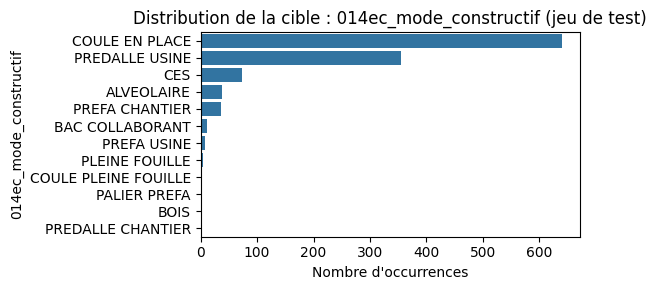

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pour KNN, il n'y a pas d'attribut feature_importances_
# On peut simplement afficher les features utilisées après preprocessing

# Récupérer les noms des features après preprocessing
feature_names = []
if 'preprocessor' in pipeline.named_steps:
    preprocessor = pipeline.named_steps['preprocessor']
    num_features_out = num_features
    # Pour les features catégorielles, récupérer les noms encodés
    cat_features_out = []
    if cat_features:
        encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
        cat_features_out = encoder.get_feature_names_out(cat_features)
    feature_names = list(num_features_out) + list(cat_features_out)
else:
    feature_names = list(X.columns)

import seaborn as sns

# Afficher la distribution de chaque cible sur y_test
for col in y_test.columns:
    plt.figure(figsize=(6, 3))
    sns.countplot(y=y_test[col], order=y_test[col].value_counts().index)
    plt.title(f"Distribution de la cible : {col} (jeu de test)")
    plt.xlabel("Nombre d'occurrences")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [11]:
from sklearn.metrics import classification_report

# Classification report pour chaque cible séparément
for i, col in enumerate(y_test.columns):
	print(f"=== Classification Report for {col} ===")
	print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

=== Classification Report for 011ec_lot ===
              precision    recall  f1-score   support

  ETANCHEITE       1.00      1.00      1.00        25
          GO       1.00      1.00      1.00      1099
  METALLIQUE       1.00      0.94      0.97        31
   PLATRERIE       1.00      1.00      1.00        18

    accuracy                           1.00      1173
   macro avg       1.00      0.98      0.99      1173
weighted avg       1.00      1.00      1.00      1173

=== Classification Report for 012ec_ouvrage ===
              precision    recall  f1-score   support

         CES       0.99      0.99      0.99        74
     CORBEAU       1.00      1.00      1.00         1
     DALLAGE       0.89      0.62      0.73        53
DALLE PORTEE       0.36      0.40      0.38        20
    LONGRINE       1.00      1.00      1.00         3
    PLANCHER       0.95      0.99      0.97       980
      RADIER       1.00      0.33      0.50        21
RADIER FOSSE       0.00      0.00      0

/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this 